# Лабораторная работа №2: Обработка признаков (часть 2)
**Выполнил:** Бибиков Павел, ИУ5-22М

## Цель лабораторной работы:
Изучение продвинутых способов предварительной обработки данных для дальнейшего формирования моделей.

## Задание:
1. Выбрать один или несколько наборов данных (датасетов) для решения следующих задач. Каждая задача может быть решена на отдельном датасете, или несколько задач могут быть решены на одном датасете. Просьба не использовать датасет, на котором данная задача решалась в лекции.
2. Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
    * масштабирование признаков (не менее чем тремя способами);
    * обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);
    * обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);
    * отбор признаков:
        * один метод из группы методов фильтрации (filter methods);
        * один метод из группы методов обертывания (wrapper methods);
        * один метод из группы методов вложений (embedded methods).

In [1]:
# --- Импорт необходимых библиотек ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # для обработки нестандартных признаков, если понадобится

# Для масштабирования
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

# Для отбора признаков
from sklearn.feature_selection import SelectKBest, f_classif # Filter
from sklearn.feature_selection import RFE # Wrapper
from sklearn.linear_model import LogisticRegression # For RFE & Embedded
from sklearn.ensemble import RandomForestClassifier # For Embedded (alternative)
from sklearn.feature_selection import SelectFromModel # Embedded

# Настройки для лучшего отображения
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# --- Загрузка данных ---
try:
    df_original = pd.read_csv('StudentsPerformance.csv')
except FileNotFoundError:
    print("Файл 'StudentsPerformance.csv' не найден. Пожалуйста, скачайте его и поместите в нужную директорию.")
    # Для примера создадим DataFrame с похожей структурой, если файл не найден
    data_placeholder = {
        'gender': ['female', 'male', 'female', 'male', 'female'] * 200,
        'race/ethnicity': ['group B', 'group C', 'group A', 'group D', 'group E'] * 200,
        'parental level of education': ["bachelor's degree", "some college", "master's degree", "associate's degree", "high school"] * 200,
        'lunch': ['standard', 'free/reduced', 'standard', 'free/reduced', 'standard'] * 200,
        'test preparation course': ['none', 'completed', 'none', 'completed', 'none'] * 200,
        'math score': np.random.randint(0, 101, 1000),
        'reading score': np.random.randint(0, 101, 1000),
        'writing score': np.random.randint(0, 101, 1000)
    }
    df_original = pd.DataFrame(data_placeholder)
    print("Создан демонстрационный DataFrame.")

# Преобразуем названия колонок
df_original.columns = df_original.columns.str.replace(' ', '_') \
                                     .str.replace('/', '_') \
                                     .str.replace(r'[\(\)]', '', regex=True)

print("Исходные данные (первые 5 строк):")
print(df_original.head())

# Определим числовые признаки для дальнейших операций
numerical_cols = ['math_score', 'reading_score', 'writing_score']
df_numeric = df_original[numerical_cols].copy()

Исходные данные (первые 5 строк):
   gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


## 1. Масштабирование признаков
Масштабирование изменяет диапазон значений признаков, не меняя форму их распределения. Это важно для многих алгоритмов машинного обучения.

In [3]:
# Копия датафрейма для масштабирования
df_scaled = df_numeric.copy()

In [4]:
# --- 1.1 StandardScaler ---
# Центрирует данные (среднее=0) и масштабирует к единичной дисперсии (std=1)
scaler_standard = StandardScaler()
df_scaled_standard = pd.DataFrame(scaler_standard.fit_transform(df_numeric), columns=numerical_cols)

print("\n--- StandardScaler ---")
print(df_scaled_standard.describe().round(2))


--- StandardScaler ---
       math_score  reading_score  writing_score
count     1000.00        1000.00        1000.00
mean         0.00           0.00          -0.00
std          1.00           1.00           1.00
min         -4.36          -3.57          -3.82
25%         -0.60          -0.70          -0.68
50%         -0.01           0.06           0.06
75%          0.72           0.67           0.72
max          2.24           2.11           2.10


In [5]:
# --- 1.2 MinMaxScaler ---
# Масштабирует данные в диапазон [0, 1] (по умолчанию)
scaler_minmax = MinMaxScaler()
df_scaled_minmax = pd.DataFrame(scaler_minmax.fit_transform(df_numeric), columns=numerical_cols)

print("\n--- MinMaxScaler ---")
print(df_scaled_minmax.describe().round(2))


--- MinMaxScaler ---
       math_score  reading_score  writing_score
count     1000.00        1000.00        1000.00
mean         0.66           0.63           0.65
std          0.15           0.18           0.17
min          0.00           0.00           0.00
25%          0.57           0.51           0.53
50%          0.66           0.64           0.66
75%          0.77           0.75           0.77
max          1.00           1.00           1.00


In [6]:
# --- 1.3 RobustScaler ---
# Использует медиану и межквартильный размах, устойчив к выбросам
scaler_robust = RobustScaler()
df_scaled_robust = pd.DataFrame(scaler_robust.fit_transform(df_numeric), columns=numerical_cols)

print("\n--- RobustScaler ---")
print(df_scaled_robust.describe().round(2))


--- RobustScaler ---
       math_score  reading_score  writing_score
count     1000.00        1000.00        1000.00
mean         0.00          -0.04          -0.04
std          0.76           0.73           0.72
min         -3.30          -2.65          -2.78
25%         -0.45          -0.55          -0.53
50%          0.00           0.00           0.00
75%          0.55           0.45           0.47
max          1.70           1.50           1.46


In [7]:
# --- 1.4 MaxAbsScaler (дополнительно) ---
# Масштабирует каждый признак путем деления на максимальное абсолютное значение.
# Полезен для данных, уже центрированных около нуля или для разреженных данных.
scaler_maxabs = MaxAbsScaler()
df_scaled_maxabs = pd.DataFrame(scaler_maxabs.fit_transform(df_numeric), columns=numerical_cols)

print("\n--- MaxAbsScaler ---")
print(df_scaled_maxabs.describe().round(2))


--- MaxAbsScaler ---
       math_score  reading_score  writing_score
count     1000.00        1000.00        1000.00
mean         0.66           0.69           0.68
std          0.15           0.15           0.15
min          0.00           0.17           0.10
25%          0.57           0.59           0.58
50%          0.66           0.70           0.69
75%          0.77           0.79           0.79
max          1.00           1.00           1.00


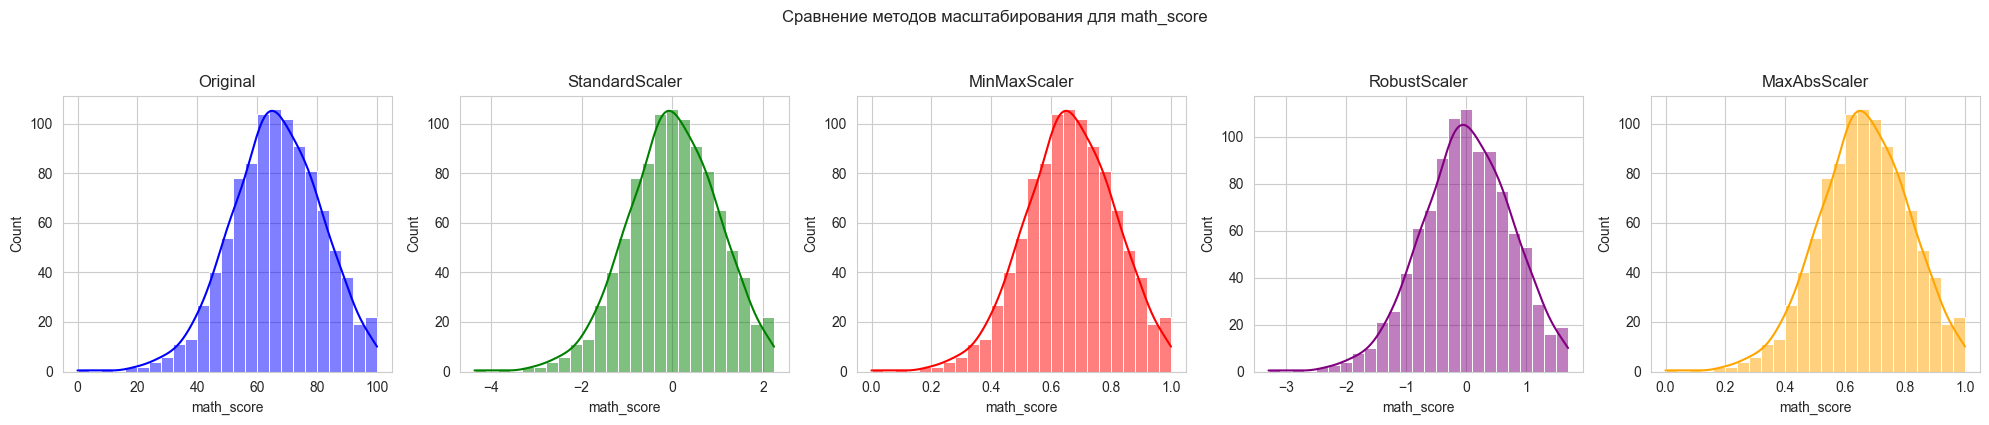

In [8]:
# Визуализация для одного признака (например, 'math_score')
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=False) # sharey=False для наглядности разных масштабов
sns.histplot(df_numeric['math_score'], ax=axes[0], kde=True, color='blue').set_title('Original')
sns.histplot(df_scaled_standard['math_score'], ax=axes[1], kde=True, color='green').set_title('StandardScaler')
sns.histplot(df_scaled_minmax['math_score'], ax=axes[2], kde=True, color='red').set_title('MinMaxScaler')
sns.histplot(df_scaled_robust['math_score'], ax=axes[3], kde=True, color='purple').set_title('RobustScaler')
sns.histplot(df_scaled_maxabs['math_score'], ax=axes[4], kde=True, color='orange').set_title('MaxAbsScaler')
plt.suptitle('Сравнение методов масштабирования для math_score', y=1.05)
plt.tight_layout()
plt.show()

## 2. Обработка выбросов
Выбросы - это значения, которые значительно отличаются от большинства других наблюдений. Будем обрабатывать их для признака math_score.

In [9]:
# Функция для определения границ выбросов по IQR
def get_outlier_boundaries(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return lower_bound, upper_bound

In [10]:
# --- 2.1 Удаление выбросов ---
# Возьмем math_score для примера
lower_math, upper_math = get_outlier_boundaries(df_original, 'math_score')
print(f"\nГраницы для math_score: Нижняя={lower_math:.2f}, Верхняя={upper_math:.2f}")

df_no_outliers_removed = df_original[(df_original['math_score'] >= lower_math) & (df_original['math_score'] <= upper_math)]
print(f"Размер до удаления выбросов: {df_original.shape}")
print(f"Размер после удаления выбросов: {df_no_outliers_removed.shape}")
print(f"Удалено {df_original.shape[0] - df_no_outliers_removed.shape[0]} строк как выбросы.")


Границы для math_score: Нижняя=27.00, Верхняя=107.00
Размер до удаления выбросов: (1000, 8)
Размер после удаления выбросов: (992, 8)
Удалено 8 строк как выбросы.


In [11]:
# --- 2.2 Замена выбросов (Capping/Winsorization) ---
df_outliers_replaced = df_original.copy()
df_outliers_replaced['math_score'] = np.where(
    df_outliers_replaced['math_score'] < lower_math,
    lower_math,
    np.where(
        df_outliers_replaced['math_score'] > upper_math,
        upper_math,
        df_outliers_replaced['math_score']
    )
)
print(f"\nКоличество значений, измененных при замене (верхний предел): {sum(df_original['math_score'] > upper_math)}")
print(f"Количество значений, измененных при замене (нижний предел): {sum(df_original['math_score'] < lower_math)}")


Количество значений, измененных при замене (верхний предел): 0
Количество значений, измененных при замене (нижний предел): 8


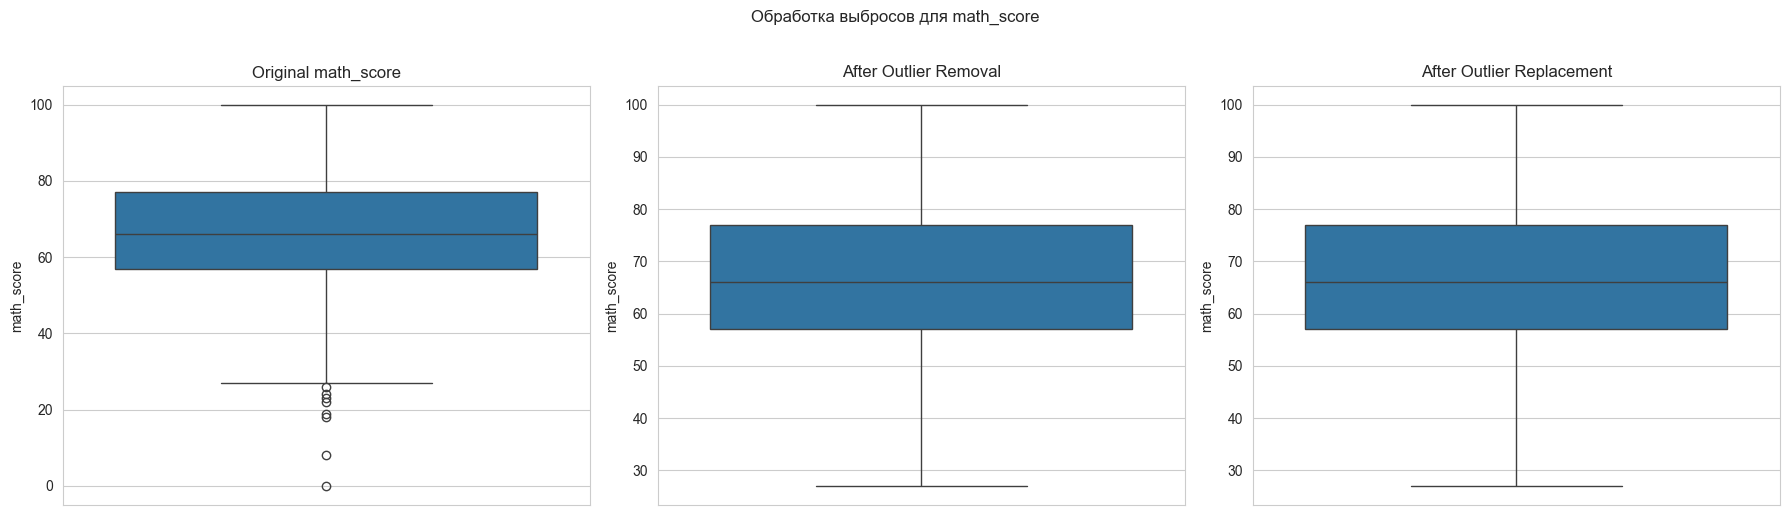

In [12]:
# Визуализация для math_score
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(y=df_original['math_score'], ax=axes[0]).set_title('Original math_score')
sns.boxplot(y=df_no_outliers_removed['math_score'], ax=axes[1]).set_title('After Outlier Removal')
sns.boxplot(y=df_outliers_replaced['math_score'], ax=axes[2]).set_title('After Outlier Replacement')
plt.suptitle('Обработка выбросов для math_score', y=1.02)
plt.tight_layout()
plt.show()

## 3. Обработка нестандартного признака
В нашем датасете нет очевидно "нестандартных" признаков. Создадим его на основе parental_level_of_education, выделив из него основной уровень образования (например, 'degree', 'college', 'high school').

In [13]:
# Копирование ДФ и функция извлечения
df_non_standard = df_original.copy()

# Признак: parental_level_of_education
# Например, мы хотим извлечь ключевое слово, указывающее на уровень:
# "degree" (bachelor's, master's), "college", "high school", "associate"

def extract_education_keyword(education_string):
    if 'degree' in education_string:
        return 'degree'
    elif 'college' in education_string:
        return 'college'
    elif 'high school' in education_string:
        return 'high_school'
    elif "associate's" in education_string: # Для associate's degree
        return 'associate'
    else:
        return 'other' # на случай непредвиденных значений

In [14]:
# Применение функции и вывод результатов    
df_non_standard['education_keyword'] = df_non_standard['parental_level_of_education'].apply(extract_education_keyword)

print("\n--- Обработка нестандартного признака (извлечение ключевого слова из образования) ---")
print(df_non_standard[['parental_level_of_education', 'education_keyword']].head(10))
print("\nРаспределение нового признака 'education_keyword':")
print(df_non_standard['education_keyword'].value_counts())


--- Обработка нестандартного признака (извлечение ключевого слова из образования) ---
  parental_level_of_education education_keyword
0           bachelor's degree            degree
1                some college           college
2             master's degree            degree
3          associate's degree            degree
4                some college           college
5          associate's degree            degree
6                some college           college
7                some college           college
8                 high school       high_school
9                 high school       high_school

Распределение нового признака 'education_keyword':
education_keyword
degree         399
high_school    375
college        226
Name: count, dtype: int64


C:\Users\mesou\AppData\Local\Temp\ipykernel_10252\1998756549.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_non_standard, x='education_keyword', palette='viridis')


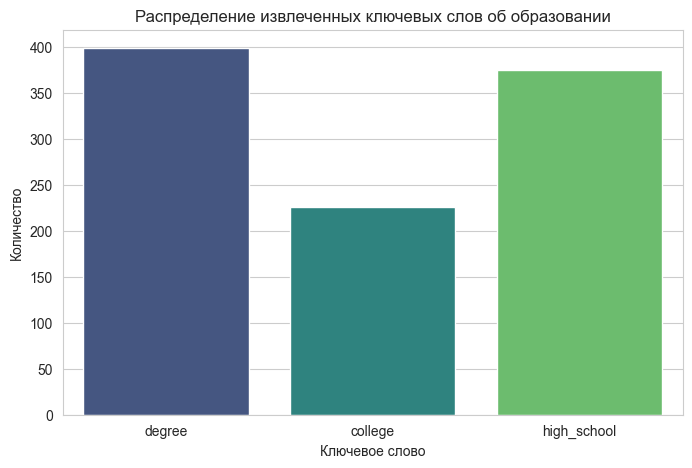

In [15]:
# Визуализация нестандартного признака
plt.figure(figsize=(8,5))
sns.countplot(data=df_non_standard, x='education_keyword', palette='viridis')
plt.title('Распределение извлеченных ключевых слов об образовании')
plt.xlabel('Ключевое слово')
plt.ylabel('Количество')
plt.show()

## 4. Отбор признаков
Для отбора признаков нам понадобится целевая переменная. Создадим ее: passed_math (1 если math_score >= 50, иначе 0).
Также, для многих методов отбора все признаки должны быть числовыми. Мы будем использовать One-Hot Encoding для категориальных.

In [16]:
# Подготовка данных для отбора признаков (копирование, создание цели)
df_selection = df_original.copy()

# 1. Создание целевой переменной
threshold = 50
df_selection['passed_math'] = (df_selection['math_score'] >= threshold).astype(int)

In [17]:
# One-Hot Encoding категориальных признаков
# 2. Подготовка признаков (X) и цели (y)
# Для отбора признаков преобразуем категориальные в числовые с помощью One-Hot Encoding
categorical_features = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
df_selection_encoded = pd.get_dummies(df_selection, columns=categorical_features, drop_first=True)

In [18]:
# Определение X и y, обработка NaN (если есть)
# Признаки (X) и Цель (y)
# Удалим исходные числовые оценки, чтобы избежать прямой утечки данных при предсказании 'passed_math'
# и оставим только категориальные и, возможно, другие обработанные признаки.
# В данном случае, для простоты, будем использовать только оригинальные категориальные признаки + числовые оценки (кроме math_score)
# как предикторы.

# Если хотим использовать reading_score и writing_score как предикторы:
X = df_selection_encoded.drop(['passed_math', 'math_score'], axis=1)
# Если НЕ хотим использовать другие баллы как предикторы (оставим только категории и прочее):
# X = df_selection_encoded.drop(['passed_math', 'math_score', 'reading_score', 'writing_score'], axis=1)

y = df_selection['passed_math']

# Заполним NaN, если они вдруг появились после get_dummies (маловероятно, но на всякий случай)
# или если какие-то признаки были удалены ранее и привели к NaN при drop
X = X.fillna(0) # Простая стратегия заполнения для примера

In [19]:
# --- 4.1 Filter method: SelectKBest с f_classif ---
# Выбирает K лучших признаков на основе ANOVA F-теста.
k_best_selector = SelectKBest(score_func=f_classif, k=5) # Выберем 5 лучших
X_kbest = k_best_selector.fit_transform(X, y)
selected_features_filter = X.columns[k_best_selector.get_support()]

print("\n--- Filter Method (SelectKBest) ---")
print(f"Выбранные {len(selected_features_filter)} признаков: {list(selected_features_filter)}")

# Можно посмотреть оценки, если интересно
# feature_scores = pd.DataFrame({'feature': X.columns, 'score': k_best_selector.scores_})
# print(feature_scores.sort_values(by='score', ascending=False).head(10))


--- Filter Method (SelectKBest) ---
Выбранные 5 признаков: ['reading_score', 'writing_score', 'gender_male', 'lunch_standard', 'test_preparation_course_none']


In [20]:
# --- 4.2 Wrapper method: RFE (Recursive Feature Elimination) ---
# Рекурсивно удаляет признаки и строит модель на оставшихся.
estimator_rfe = LogisticRegression(solver='liblinear', max_iter=200, random_state=42)
rfe_selector = RFE(estimator=estimator_rfe, n_features_to_select=5, step=1) # Выберем 5 признаков
rfe_selector = rfe_selector.fit(X, y)
selected_features_wrapper = X.columns[rfe_selector.support_]

print("\n--- Wrapper Method (RFE with Logistic Regression) ---")
print(f"Выбранные {len(selected_features_wrapper)} признаков: {list(selected_features_wrapper)}")


--- Wrapper Method (RFE with Logistic Regression) ---
Выбранные 5 признаков: ['gender_male', 'race_ethnicity_group E', 'parental_level_of_education_some high school', 'lunch_standard', 'test_preparation_course_none']


In [21]:
# --- 4.3 Embedded method: SelectFromModel с LogisticRegression (L1) ---
# Модели с L1-регуляризацией обнуляют коэффициенты маловажных признаков.
estimator_embedded = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, random_state=42) # C - обратная сила регуляризации
sfm_selector = SelectFromModel(estimator_embedded, threshold=-np.inf, max_features=5) # max_features для выбора топ-5
sfm_selector.fit(X, y)
selected_features_embedded = X.columns[sfm_selector.get_support()]

print("\n--- Embedded Method (SelectFromModel with L1 Logistic Regression) ---")
print(f"Выбранные {len(selected_features_embedded)} признаков: {list(selected_features_embedded)}")


--- Embedded Method (SelectFromModel with L1 Logistic Regression) ---
Выбранные 5 признаков: ['reading_score', 'writing_score', 'gender_male', 'race_ethnicity_group B', 'lunch_standard']
